## Bayesian Examples in Python

In [1]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline



import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

In [2]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([5, 3, 1])



# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

[Calculate Expected Value](https://en.wikipedia.org/wiki/Categorical_distribution#Bayesian_inference_using_conjugate_prior)

In [3]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


### Maximum A Posterior Estimation
The maximum a posterior (MAP) estimate is simply going to be the prevalence seen in the data. This is a frequentist way of viewing the world.

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

In [4]:
display_probs(dict(zip(animals, (alphas + c - 1) / sum(alphas + c - 1))))

Species: lions    Prevalence: 55.56%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 11.11%.


### Bayesian Model

In [8]:
## Change n to match total prior observations

with pm.Model() as model:
    # Dirichlet hyperparameters are uniform hyperpriors
    hyperpriors = pm.Uniform('hyperpriors', shape = 3, observed = alphas)
    # Probabilities for each species
    parameters = pm.Dirichlet('parameters', a=hyperpriors, shape=3)
    # Observed data is a multinomial distribution with 6 trials
    observed_data = pm.Multinomial(
        'observed_data', n=9, p=parameters, shape=3, observed=c)

In [9]:
model

In [10]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2945.31draws/s]


In [11]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lions,0.501709,0.136197,0.002591,0.232629,0.755868,2719.167423,0.999803
tigers,0.329002,0.126492,0.002625,0.111658,0.587251,2515.049929,1.002221
bears,0.169289,0.103884,0.002107,0.006115,0.382436,2283.994214,1.001800


In [12]:
# Tuning samples
tune_df = pd.DataFrame(trace['parameters'][:1000], columns = animals)
tune_df['tune'] = True

# Samples after tuning
trace_df = pd.DataFrame(trace['parameters'][1000:], columns = animals)
trace_df['tune'] = False

all_df = pd.concat([tune_df, trace_df])

pvals = trace_df.iloc[:, :3].mean(axis = 0)
trace_df.head()

,lions,tigers,bears,tune
0,0.514230,0.425052,0.060717,False
1,0.658195,0.105572,0.236233,False
2,0.656194,0.301827,0.041979,False
3,0.363857,0.628108,0.008034,False
4,0.454189,0.493957,0.051854,False


In [13]:
trace_df.iloc[:, :3].apply(lambda x: np.percentile(x, 5)).to_frame().rename(columns = {0: '5th percentile'})

,5th percentile
lions,0.269261
tigers,0.135169
bears,0.038505


In [14]:
## 95% range of uncertainity (Large amount of uncertinity given the small sampling size)
trace_df.iloc[:, :3].apply(lambda x: np.percentile(x, 95)).to_frame().rename(columns = {0: '95th percentile'})

,95th percentile
lions,0.719030
tigers,0.546186
bears,0.393387


### Diagonistic Plots

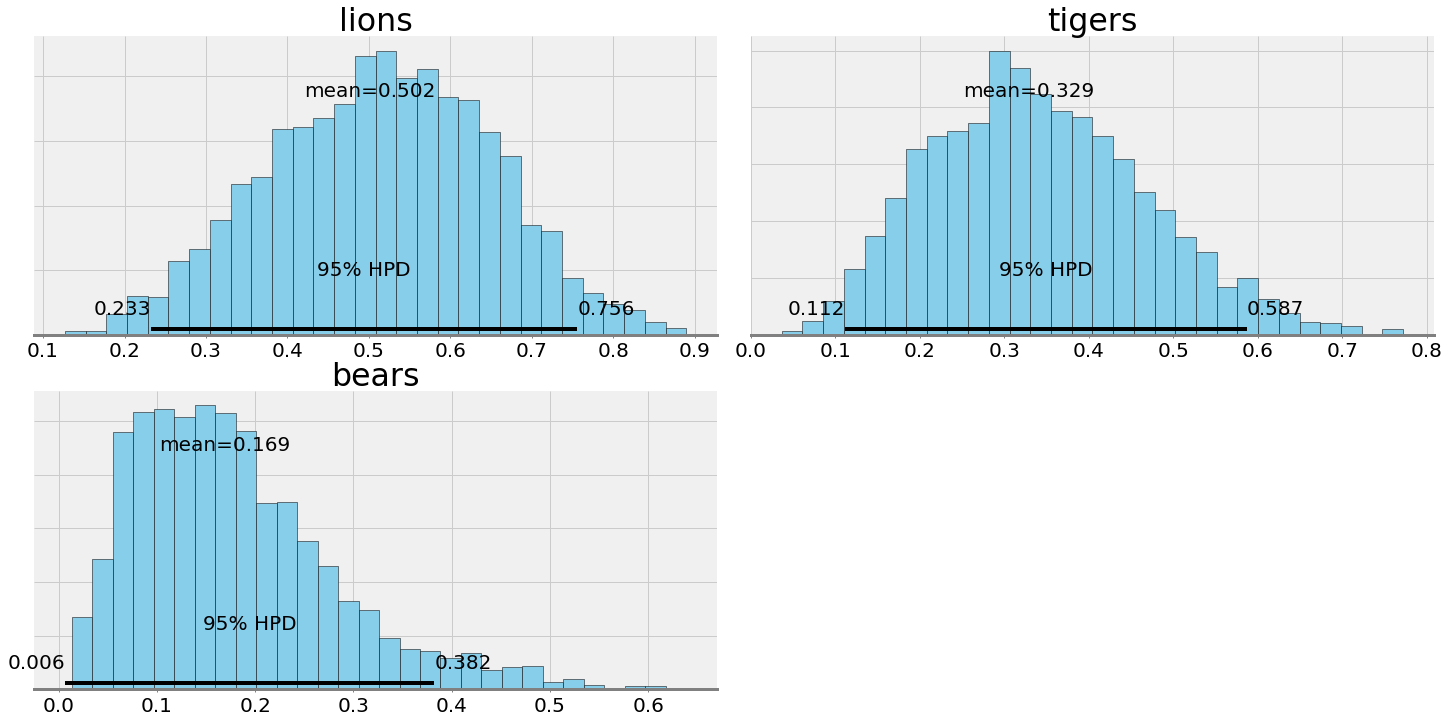

In [15]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10), edgecolor = 'k');

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

The traceplot shows a kernel density estimate and all the samples that were drawn on the right. We collapse the chains on th plots (combined = True) but in reality we drew 2 independent chains.



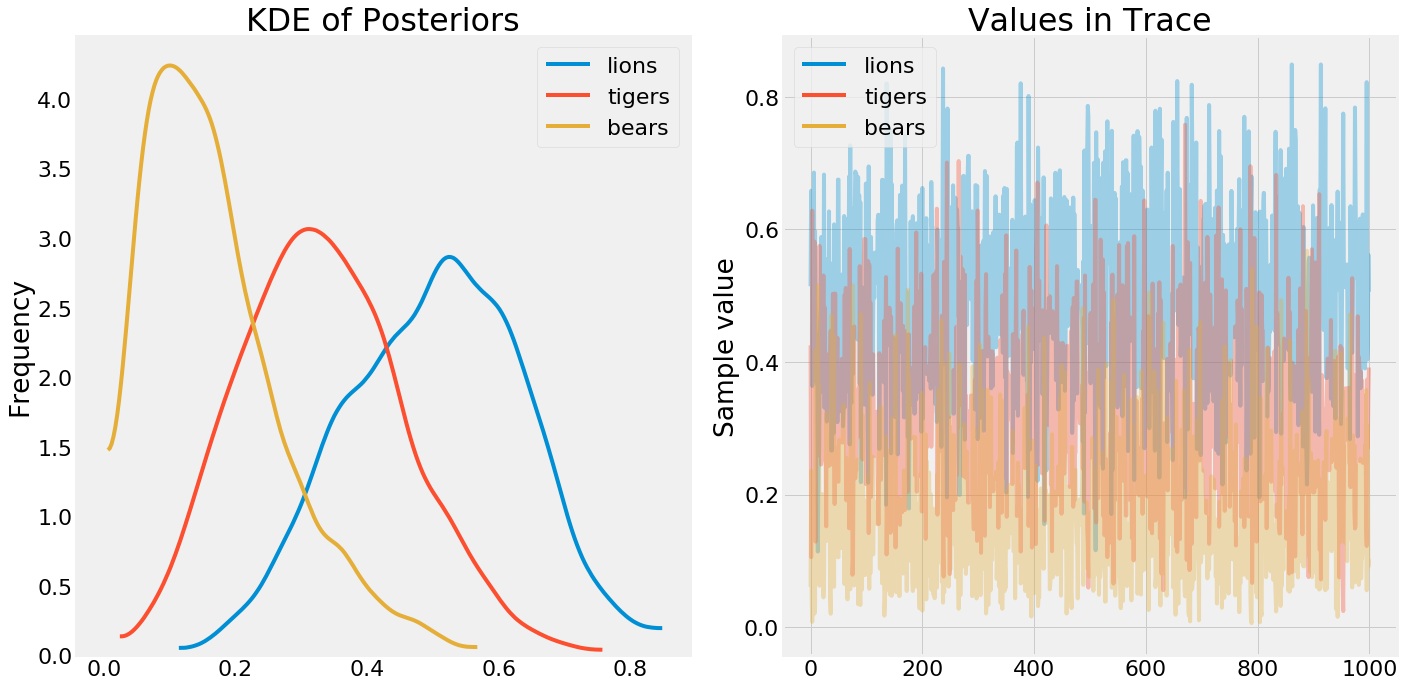

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 10), combined = True,skip_first = 1000);
ax[0][0].set_title('KDE of Posteriors'); ax[0][1].set_title('Values in Trace');
add_legend(ax[0][0])
add_legend(ax[0][1])

### Maximum A Posteriori Result with PyMC3
The MAP estimates are exactly the same as the observations. These are also the results that a frequentist would come up with!

In [17]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))

logp = -2.9718, ||grad|| = 2.2361: 100%|██████████| 8/8 [00:00<00:00, 2491.97it/s]

Species: lions    Prevalence: 55.56%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 11.11%.


In [18]:
with model:
    samples = pm.sample_ppc(trace, samples = 1000)
    
dict(zip(animals, samples['observed_data'].mean(axis = 0)))

100%|██████████| 1000/1000 [00:01<00:00, 910.27it/s]


{'bears': 1.583, 'lions': 4.403, 'tigers': 3.014}

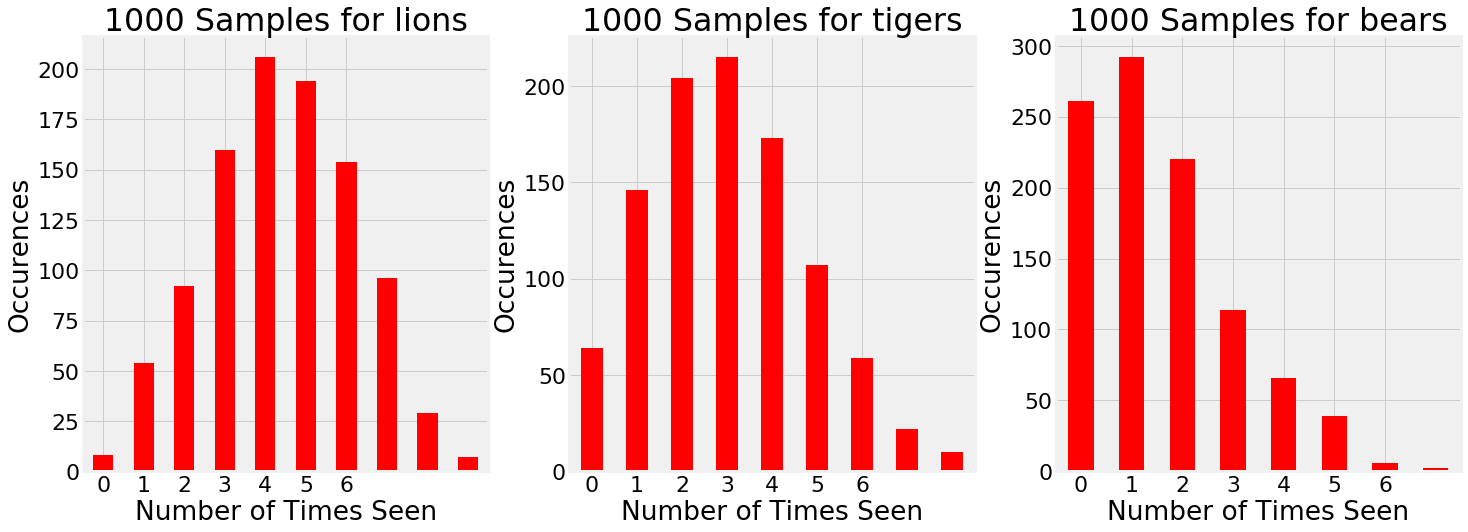

In [19]:
sample_df = pd.DataFrame(samples['observed_data'], columns = animals)

plt.figure(figsize = (22, 8))
for i, animal in enumerate(sample_df):
    plt.subplot(1, 3, i+1)
    sample_df[animal].value_counts().sort_index().plot.bar(color = 'r');
    plt.xticks(range(7), range(7), rotation = 0);
    plt.xlabel('Number of Times Seen'); plt.ylabel('Occurences');
    plt.title(f'1000 Samples for {animal}');

### Dirichlet Distributions

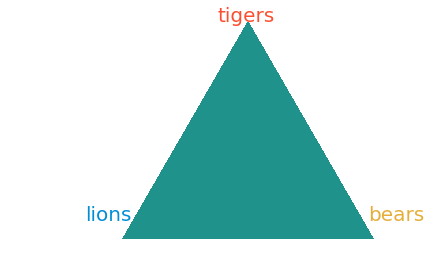

In [20]:
draw_pdf_contours(Dirichlet(alphas))
annotate_plot()

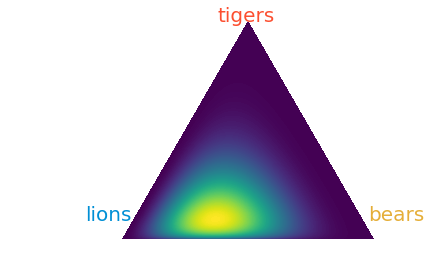

In [24]:
draw_pdf_contours(Dirichlet(9*pvals))
annotate_plot()

### Probability of Next Observation

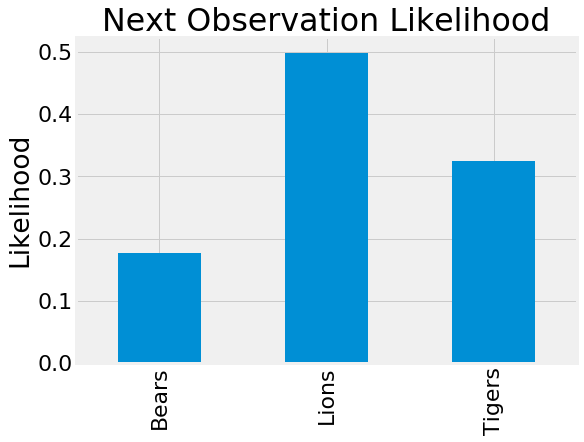

In [22]:
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [23]:
next_obs

,variable,value,total
1,Bears,1,0.1770
3,Lions,1,0.4988
5,Tigers,1,0.3242


In [ ]:
all_df = pd.melt(all_df, id_vars=['tune'], 
                   var_name='animal', value_name='posterior')

plt.rcParams['font.size'] = 20
g = sns.FacetGrid(data = all_df, hue = 'tune', col = 'animal', size = 6)
g.map(sns.kdeplot, 'posterior');
l = plt.legend(prop={'size': 20});
l.set_title('Tune');
g.set_ylabels(label = 'Density')

In [ ]:
summary